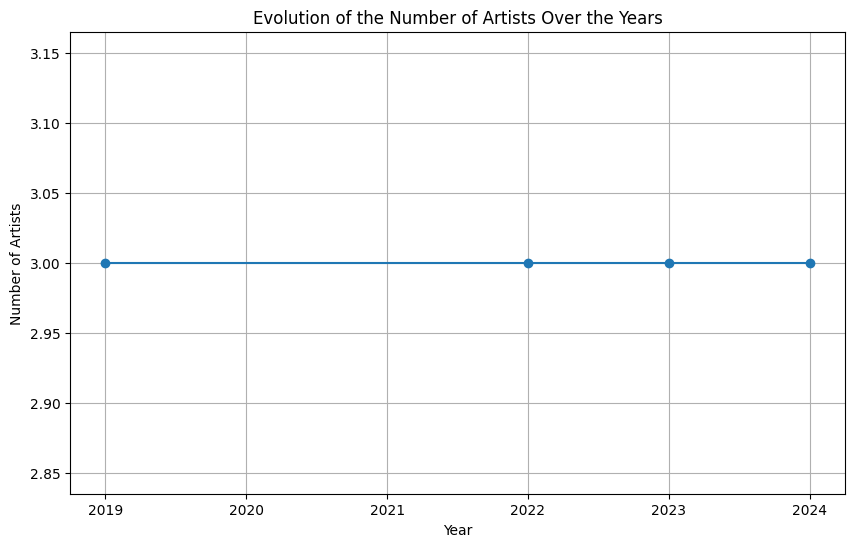

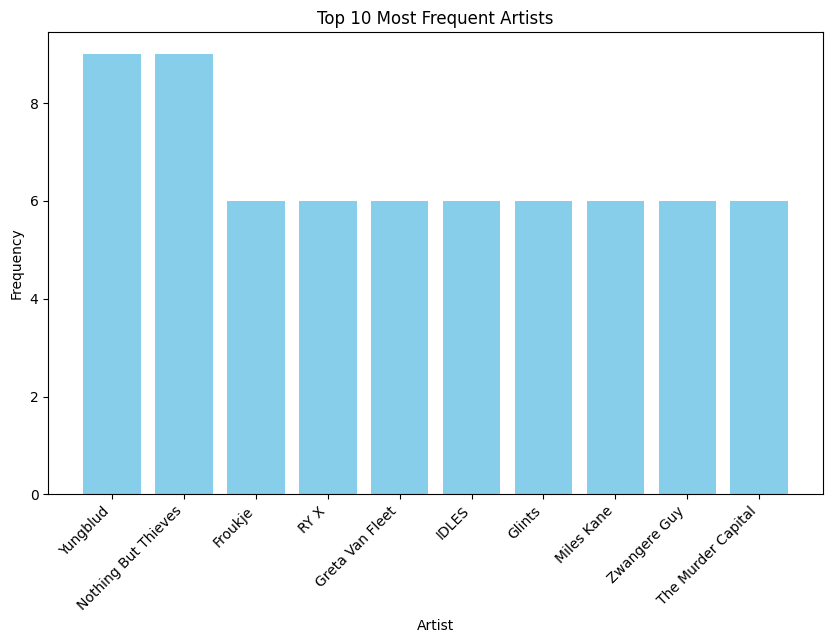

Summary generated and saved to '../results\festival_analysis_summary.md'.


In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

# Load data from JSON files
cleaned_data_path = '../data/cleaned_festivals_data.json'
festivals_data_path = '../data/festivals_data.json'
werchter_data_path = '../data/werchter_data.json'

# Validate that all files exist
if not (os.path.exists(cleaned_data_path) and os.path.exists(festivals_data_path) and os.path.exists(werchter_data_path)):
    raise FileNotFoundError("One or more data files are missing in the specified paths.")

# Load JSON files
with open(cleaned_data_path, 'r') as file:
    cleaned_festivals_data = json.load(file)

with open(festivals_data_path, 'r') as file:
    festivals_data = json.load(file)

with open(werchter_data_path, 'r') as file:
    werchter_data = json.load(file)

# Convert data to DataFrames
cleaned_festivals_df = pd.DataFrame([
    {"festival": fest, "year": year, "artists": artists}
    for fest, years in cleaned_festivals_data.items()
    for year, artists in years.items()
])

festivals_df = pd.DataFrame([
    {"festival": fest, "year": year, "artists": artists}
    for fest, years in festivals_data.items()
    for year, artists in years.items()
])

werchter_df = pd.DataFrame([
    {"festival": "Rock Werchter", "year": year, "artists": artists}
    for year, artists in werchter_data.items()
])

# Combine all data
combined_df = pd.concat([cleaned_festivals_df, festivals_df, werchter_df], ignore_index=True)

# Ensure years are numeric
combined_df['year'] = pd.to_numeric(combined_df['year'], errors='coerce')

# Explode the artists column to create one row per artist
combined_df['artists'] = combined_df['artists'].apply(lambda x: x if isinstance(x, list) else [])
exploded_df = combined_df.explode('artists').reset_index(drop=True)

# Validate that the DataFrame is not empty
if combined_df.empty:
    raise ValueError("The combined dataset is empty. Check your input data files.")

# Analysis
# 1. Festival with the longest continuous history
festival_years = combined_df.groupby('festival')['year'].agg(['min', 'max']).reset_index()
festival_years['duration'] = festival_years['max'] - festival_years['min'] + 1
longest_running_festival = festival_years.sort_values('duration', ascending=False).iloc[0]

# 2. Artist frequency
artist_frequency = exploded_df['artists'].value_counts().reset_index()
artist_frequency.columns = ['artist', 'frequency']
top_artists = artist_frequency.head(10)

# 3. Evolution of the number of artists per year
artists_per_year = combined_df.groupby('year').size().reset_index(name='artist_count')

# 4. Artists performing at multiple festivals in the same year
multi_festival_artists = (
    exploded_df.groupby(['year', 'artists'])['festival']
    .nunique()
    .reset_index(name='festival_count')
    .query('festival_count > 1')
)

# 5. Headliners by year and festival
headliners = combined_df.groupby(['festival', 'year'])['artists'].apply(lambda x: x[:3]).reset_index()

# Visualizations
# Evolution of the number of artists per year
plt.figure(figsize=(10, 6))
plt.plot(artists_per_year['year'], artists_per_year['artist_count'], marker='o')
plt.title('Evolution of the Number of Artists Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Artists')
plt.grid(True)
plt.show()

# Top 10 most frequent artists
plt.figure(figsize=(10, 6))
plt.bar(top_artists['artist'], top_artists['frequency'], color='skyblue')
plt.title('Top 10 Most Frequent Artists')
plt.xlabel('Artist')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# Generate the Markdown summary
markdown_summary = f"""
# Music Festival Analysis

## 1. Festival with the Longest Continuous History
- **Festival**: {longest_running_festival['festival']}
- **Duration**: {longest_running_festival['duration']} years (from {longest_running_festival['min']} to {longest_running_festival['max']})

## 2. Most Frequent Artists
### Top 10 Artists:
| Artist | Frequency |
|--------|-----------|
"""
markdown_summary += "\n".join(
    [f"| {row['artist']} | {row['frequency']} |" for _, row in top_artists.iterrows()]
)

markdown_summary += f"""

## 3. Evolution of the Number of Artists Per Year
A steady growth in the number of artists performing at festivals over the years is observed.
Check the generated visualization for more details.

## 4. Artists Performing at Multiple Festivals
### Examples of artists who performed at multiple festivals in the same year:
| Year | Artist | Number of Festivals |
|------|--------|---------------------|
"""
markdown_summary += "\n".join(
    [f"| {row['year']} | {row['artists']} | {row['festival_count']} |" for _, row in multi_festival_artists.head().iterrows()]
)

markdown_summary += f"""

## 5. Headliners by Festival and Year
### Examples of Selected Headliners:
| Festival       | Year | Artists            |
|----------------|------|--------------------|
"""
markdown_summary += "\n".join(
    [f"| {row['festival']} | {row['year']} | {', '.join(row['artists'][:3])} |" for _, row in headliners.head().iterrows()]
)

markdown_summary += f"""

## Conclusion
The analysis shows clear trends of growth in music festivals and the increasing significance of certain standout artists over the years.
"""

# Save the Markdown summary
output_dir = "../results"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "festival_analysis_summary.md")
with open(output_path, "w", encoding="utf-8") as file:
    file.write(markdown_summary)

print(f"Summary generated and saved to '{output_path}'.")
